In [71]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# for returning search results
from fuzzywuzzy import fuzz

# visualization imports
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

# 1. Load Data

In [3]:
df_movies = pd.read_csv('DATA_PATH', 
                        dtype = {'movieId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv('DAtA_PATH',
                        dtype = {'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
df_tags = pd.read_csv('DATA_PATH')


In [315]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [316]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
userId       3683 non-null int64
movieId      3683 non-null int64
tag          3683 non-null object
timestamp    3683 non-null int64
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [309]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 2 columns):
movieId    9742 non-null int32
title      9742 non-null object
dtypes: int32(1), object(1)
memory usage: 114.2+ KB


In [310]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [35]:
df_ratings.rating.isnull().all()  # no null in rating

False

In [36]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
userId     100836 non-null int32
movieId    100836 non-null int32
rating     100836 non-null float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB


In [21]:
# number of unique users
num_users = len(df_ratings.userId.unique())  # 610
num_items = len(df_ratings.movieId.unique()) # 9724
print('There are {} nuique users and {} unique movies.'.format(num_users,num_items))

There are 610 nuique users and 9724 unique movies.


# 2. EDA

#### 1. Plot the count of each rating

In [42]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(),columns = ['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [33]:
# does not include ratings that scores 0
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
rating_zero_cnt

5830804

In [43]:
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(pd.DataFrame({'count':rating_zero_cnt},index=[0.0]),
                                          verify_integrity=True).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [50]:
# The count for zero rating is too big, uncomparable with other scores, making it difficult to plot.
# Will take log ransformation
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt.index.name = 'rating_score'
df_ratings_cnt

,count,log_count
rating_score,,
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829


Text(0.5, 1.0, 'Log Counts of Rating Scores')

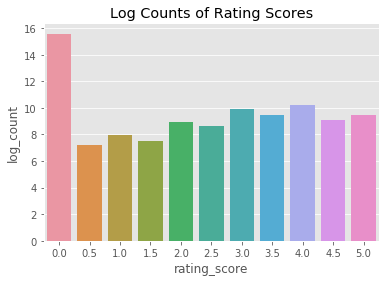

In [72]:
import seaborn as sns
plot1 = sns.barplot(x=df_ratings_cnt.index,y='log_count',data = df_ratings_cnt)
plot1.set_title('Log Counts of Rating Scores')
# pattern: there are more people giving 3.0 or 4.0 than other scores.

#### 2. Plot rating frequency of all movies

In [76]:
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(),columns = ['count'])
df_movies_cnt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0.5, 1.0, 'Rating Frequency of all movies')

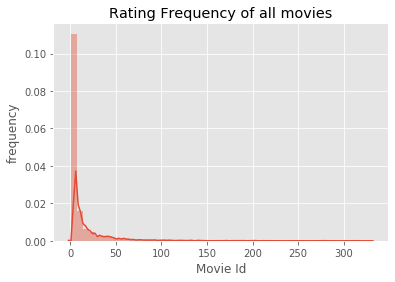

In [103]:
ax = sns.distplot(df_movies_count)
ax.set_xlabel('Movie Id')
ax.set_ylabel('frequency')
ax.set_title('Rating Frequency of all movies')

In [ ]:
# The long tail shape (highly skewed distribution) is reasonal because only a small fraction of movies are frequently rated by users (i.e. popular 
# movies). The majority are rarely rated.


Text(0, 0.5, 'number of ratings (log scale)')

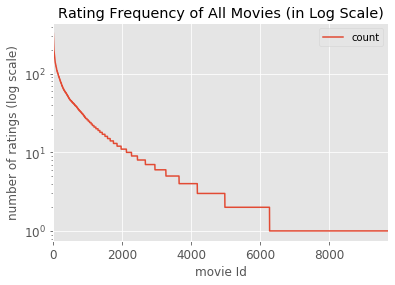

In [78]:
# log transformation
import matplotlib.pyplot as plt
plot2 = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(6, 4),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
plot2.set_xlabel("movie Id")
plot2.set_ylabel("number of ratings (log scale)")

# About 2000 movies out of 9724 (20%) are rated more than 10 times.

In [86]:
df_movies_cnt['count'].quantile(np.arange(1,0.40,-0.05))
# About 1% movies has 329 or more ratings, 5% has 47 or more

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
0.60      4.0
0.55      3.0
0.50      3.0
0.45      2.0
Name: count, dtype: float64

#### Select only popular movies - avoid sparse matrix

In [107]:
# filter data
# top 20%: movies has more than 10 ratings 
popularity_thres = 10
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_unpop = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('Shape of original dataset:{}'.format(df_ratings.shape))
print('Shape of ratings data after dropping unpopular movies:{}'.format(df_ratings_drop_unpop.shape))

Shape of original dataset:(100836, 3)
Shape of ratings data after dropping unpopular movies:(81116, 3)


#### Filter user - drop inactive users

In [97]:
df_users_cnt = pd.DataFrame(df_ratings.groupby('userId').size(),columns = ['count'])
df_users_cnt.head()

,count
userId,
1,232
2,29
3,39
4,216
5,44


Text(0.5, 1.0, 'Rating Frequency of all users')

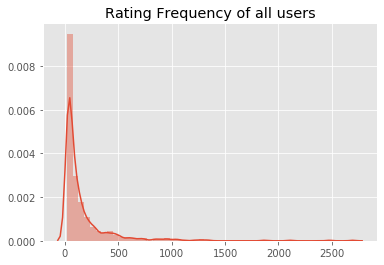

In [102]:
plot3 = sns.distplot(df_users_cnt)
plot3.set_title('Rating Frequency of all users')

Text(0, 0.5, 'Number of ratings')

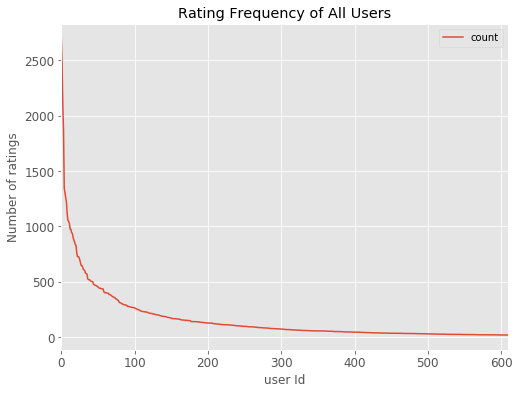

In [104]:
plot3 = df_users_cnt.sort_values('count',ascending = False) \
         .reset_index(drop = True) \
         .plot(figsize=(8, 6),
              title = 'Rating Frequency of All Users',
              fontsize = 12)
plot3.set_xlabel('user Id')
plot3.set_ylabel('Number of ratings')

In [106]:
df_users_cnt['count'].quantile(np.arange(1,0,-0.05))

1.00    2698.00
0.95     610.75
0.90     400.30
0.85     278.30
0.80     216.00
0.75     168.00
0.70     140.00
0.65     119.00
0.60     101.40
0.55      84.95
0.50      70.50
0.45      60.00
0.40      54.00
0.35      46.15
0.30      40.00
0.25      35.00
0.20      32.00
0.15      27.00
0.10      24.00
0.05      22.00
Name: count, dtype: float64

In [110]:
# long tail property as well. 
# limit users to top 70% 
user_thres = 40
active_users = list(df_users_cnt.query('count >= @user_thres').index)
df_ratings_drop_users = df_ratings_drop_unpop[df_ratings_drop_unpop.userId.isin(active_users)]
print('Shape of ratings data after dropping both unpopular movies and inactive users:',df_ratings_drop_users.shape)

Shape of ratings data after dropping both unpopular movies and inactive users: (76395, 3)


In [111]:
df_ratings_drop_users.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


#### 4. Plot tags

In [329]:
df_tags_cnt_temp = pd.DataFrame(df_tags.groupby('tag').size(),columns = ['count'])

In [330]:
df_tags_cnt_temp.quantile(np.arange(1,0,-0.05))

,count
1.00,131.0
0.95,8.0
0.90,5.0
0.85,3.0
0.80,2.0
0.75,2.0
0.70,2.0
0.65,1.0
0.60,1.0
0.55,1.0


In [356]:
# Leave out the tail of the tags(uncommon tags, i.e. below 95%)
tag_thres = 15
common_tags = list(df_tags_cnt_temp.query('count > @tag_thres').index)
df_tags_cnt = df_tags[df_tags.tag.isin(common_tags)]
print('Shape of orginal dataset: {}'.format(df_tags.shape))
print('Shape of data after removing unpopular tags: {}'.format(df_tags_cnt.shape))

Shape of orginal dataset: (3683, 4)
Shape of data after removing unpopular tags: (533, 4)


In [364]:
df_tags_cnt2 = pd.DataFrame(df_tags_cnt.groupby('tag').size(),columns = ['count'])
df_tags_cnt2 = df_tags_cnt2.sort_values(by='count', ascending = False)

Text(0.5, 1.0, 'Frequency of Tags')

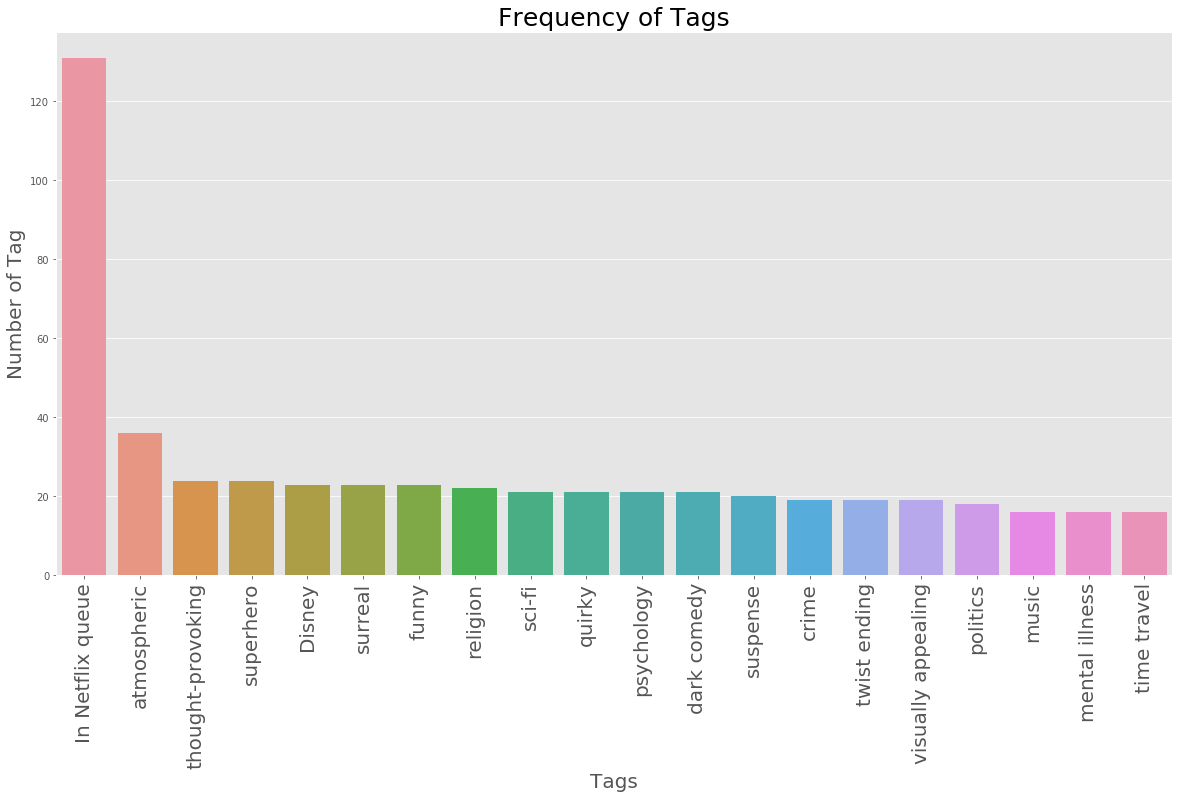

In [382]:
fig,aes = plt.subplots(figsize = (20,10))
plot4 = sns.barplot(x = df_tags_cnt2.index, y = 'count', data = df_tags_cnt2, ax = aes)
#plt.figure(figsize = (6,4))
plt.xticks(fontsize = 20,rotation = 90)
plt.xlabel('Tags',fontsize = 20)
plt.ylabel('Number of Tag',fontsize = 20)
plt.title('Frequency of Tags',fontsize = 25)

#### 5. Plot genres

In [5]:
df_movies['token']=df_movies['genres'].apply(lambda x:x.split('|'))
df_movies.head()

,movieId,title,genres,token
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [6]:
whole_corpus=''
for line in df_movies['token']:
    if line:
        whole_corpus+=' '.join(line)
        whole_corpus+=' '

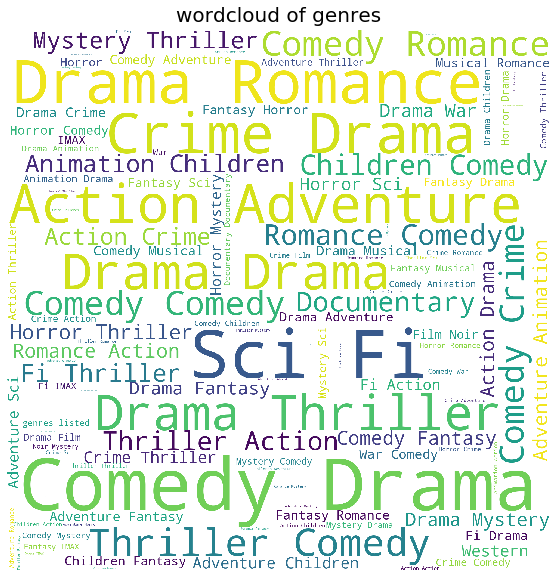

In [77]:
plt.figure(figsize = (10,10))
wordcloud=WordCloud(background_color='white',width=2000,height=2000,margin = 0).generate(whole_corpus)
plt.imshow(wordcloud)
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('wordcloud of genres',fontsize = 20)
plt.show()

In [60]:
df_rating_genre = pd.merge(df_ratings,df_movies,on='movieId',how = 'left')
df_rating_genre.head()

,userId,movieId,rating,timestamp,title,genres,token
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,"[Action, Crime, Thriller]"
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"[Mystery, Thriller]"
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"[Crime, Mystery, Thriller]"


In [62]:
total_genres=[]      # genre names
total_genres_={}     # number of each genre
genres_rating={}     # sum of ratings of each genre
for i in range(len(df_rating_genre)):
    for item in df_rating_genre['token'][i]:
        if item not in total_genres:
            total_genres.append(item)
            total_genres_[item]=1
            genres_rating[item]=df_rating_genre['rating'][i]
        else:
            total_genres_[item]+=1
            genres_rating[item]+=df_rating_genre['rating'][i]


In [66]:
# average rating of each genre
temp_={k:v/total_genres_[k] for k,v in genres_rating.items()}

Text(0.5, 1.0, 'Average Rating of Each Genre')

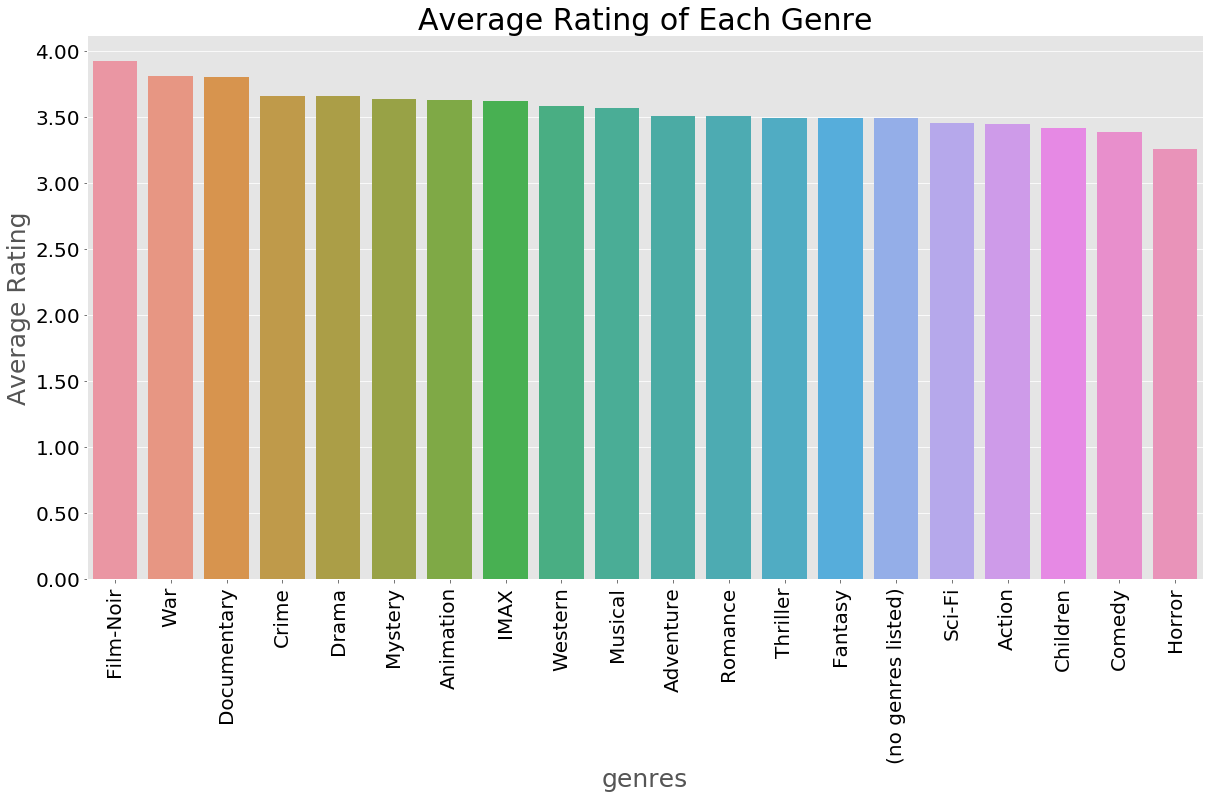

In [78]:
temp=sorted([(k,v) for k,v in temp_.items()],key=lambda x:x[1],reverse=True)
from matplotlib.ticker import FormatStrFormatter
fig,aes = plt.subplots(figsize = (20,10))
sns.barplot(x=[z[0] for z in temp],y=[z[1] for z in temp],ax=aes)
aes.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(fontsize=20,color='black',rotation=90)
plt.yticks(fontsize=20,color='black')
plt.xlabel('genres',fontsize=25)
plt.ylabel('Average Rating',fontsize=25)
plt.title('Average Rating of Each Genre',fontsize=30)

# 3. Train KNN Model for item-based collaborative filtering system

### 1. reshape the data

- we want the data to be in an (artist,user) array: each row -- movie, each column -- user.
- sparse matrix：will have missing values —— fill missing with 0

In [112]:
movie_user_mat = df_ratings_drop_users.pivot(index='movieId',columns = 'userId',values='rating').fillna(0)
movie_user_mat.head()

userId,1,4,5,6,7,8,9,10,11,14,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


- Exploration：how sparse is this matrix

In [305]:
# total number of entries
num_entries = movie_user_mat.shape[0]*movie_user_mat.shape[1]
# number of zero entries
num_zeros = (movie_user_mat == 0).sum().sum()
# percentage of zero values in the matrix
zeros = num_zeros/num_entries
print('There are about {:.2%} missing ratings in the matrix'.format(zeros))

There are about 92.13% missing ratings in the matrix


It shows the vast majority of entries are zeros, so the matrix is very sparse. 

In [116]:
# transform movie title into index
movie_to_idx = {movie: i for i, movie in 
               enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))}
movie_to_idx

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Father of the Bride Part II (1995)': 3,
 'Heat (1995)': 4,
 'Sabrina (1995)': 5,
 'Sudden Death (1995)': 6,
 'GoldenEye (1995)': 7,
 'American President, The (1995)': 8,
 'Dracula: Dead and Loving It (1995)': 9,
 'Nixon (1995)': 10,
 'Cutthroat Island (1995)': 11,
 'Casino (1995)': 12,
 'Sense and Sensibility (1995)': 13,
 'Four Rooms (1995)': 14,
 'Ace Ventura: When Nature Calls (1995)': 15,
 'Money Train (1995)': 16,
 'Get Shorty (1995)': 17,
 'Copycat (1995)': 18,
 'Assassins (1995)': 19,
 'Powder (1995)': 20,
 'Leaving Las Vegas (1995)': 21,
 'Othello (1995)': 22,
 'Persuasion (1995)': 23,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 24,
 'Dangerous Minds (1995)': 25,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 26,
 'Babe (1995)': 27,
 'Dead Man Walking (1995)': 28,
 'Clueless (1995)': 29,
 'Richard III (1995)': 30,
 'Mortal Kombat (1995)': 31,
 'To Die For (1995)': 32,
 'How to 

In [138]:
# transform movie-user matrix to scipy sparse matrix —— to be used in arithmetic operations
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)       # each array corresponds to the movie

In [130]:
# another method (but mind the index)
a = df_movies.to_dict('split')['data']
a

[[1, 'Toy Story (1995)'],
 [2, 'Jumanji (1995)'],
 [3, 'Grumpier Old Men (1995)'],
 [4, 'Waiting to Exhale (1995)'],
 [5, 'Father of the Bride Part II (1995)'],
 [6, 'Heat (1995)'],
 [7, 'Sabrina (1995)'],
 [8, 'Tom and Huck (1995)'],
 [9, 'Sudden Death (1995)'],
 [10, 'GoldenEye (1995)'],
 [11, 'American President, The (1995)'],
 [12, 'Dracula: Dead and Loving It (1995)'],
 [13, 'Balto (1995)'],
 [14, 'Nixon (1995)'],
 [15, 'Cutthroat Island (1995)'],
 [16, 'Casino (1995)'],
 [17, 'Sense and Sensibility (1995)'],
 [18, 'Four Rooms (1995)'],
 [19, 'Ace Ventura: When Nature Calls (1995)'],
 [20, 'Money Train (1995)'],
 [21, 'Get Shorty (1995)'],
 [22, 'Copycat (1995)'],
 [23, 'Assassins (1995)'],
 [24, 'Powder (1995)'],
 [25, 'Leaving Las Vegas (1995)'],
 [26, 'Othello (1995)'],
 [27, 'Now and Then (1995)'],
 [28, 'Persuasion (1995)'],
 [29, 'City of Lost Children, The (Cité des enfants perdus, La) (1995)'],
 [30, 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)'],
 [31, 'Dangerous

### 2. Fit the model

- compute similarity of items: cosine similarity
- find k similar items to item a
- recommend movies not seen by user a

In [139]:
# transform model
model_knn = NearestNeighbors(metric = 'cosine',algorithm = 'brute',n_neighbors = 20, n_jobs = -1)

In [140]:
# fit
model_knn.fit(movie_user_mat_sparse) 

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

# 4. Make recommendations using this trained model

### 1. Return search match & indedx of closest match

In [276]:
# return index of the closest match     

def fuzzy_matching(mapper, fav_movie, verbose = True):
    """
    mapper: dict, movie title: index
    fav_movie: input
    verbose: True --- print log
    """
    match_tuple = []
    for title,idx in mapper.items():
        ratio = fuzz.ratio(title.lower(),fav_movie.lower())
        partial_ratio = fuzz.partial_ratio(title.lower(),fav_movie.lower())
        WRatio = fuzz.WRatio(title.lower(),fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title,idx,ratio))
        elif partial_ratio >= 85:            # deals with series movies
            match_tuple.append((title,idx,partial_ratio))
        elif WRatio >= 90:                   # deals with punctuations
            match_tuple.append((title,idx,WRatio))
                 
    match_tuple = sorted(match_tuple, key = lambda x:x[2])[::-1]  # sort ratio in descending order
    
    if not match_tuple:         # no match           
        print('Not Found for {}.'.format(fav_movie))
        return
    if verbose:                 # display movies found
        print('Found for you: \n{}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]    # show index of the closest match (in order to refer to the user-item matrix)

### 2. Return list of top matches

In [277]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    model_knn: model
    data: movie-user matrix
    mapper: dict, movie title: index
    fav_movie: input
    n_recommendations: int, top n similar recommendations
    """
    # fit model
    model_knn.fit(data)
    # inference
    print('You have input movie: {}\n'.format(fav_movie))
    # get index of closest match of the input movie
    idx = fuzzy_matching(mapper, fav_movie,verbose = True) # use function defined before
    # Finds the K-neighbors of a point. Returns indices of and distances to the neighbors of each point.
    distances,indices = model_knn.kneighbors(data[idx],n_neighbors = n_recommendations+1)  # recommendations include itself
    
    # get index of most similar recommendations (sort by distance)
    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())),
                           key = lambda x:x[1])[:0:-1]      # remove the input itself
    
    # Now mapper is in title:index
    # reverse mapper (idx:title) 
    reverse_mapper = {v: k for k,v in mapper.items()}
    
    # print recommendations
    print('You may also interested in:')
    for i, (idx,distance) in enumerate(raw_recommends):
        print('{0}:{1}, with distance of {2}'.format(i+1, reverse_mapper[idx], distance))
    
    
    

### 3. Make recommendations

In [278]:
fav_movie = 'x men'
make_recommendation(model_knn = model_knn,data = movie_user_mat_sparse,mapper = movie_to_idx,
                    fav_movie = fav_movie, n_recommendations = 10)

You have input movie: x men

Found for you: 
['X-Men: Apocalypse (2016)', 'X-Men: Days of Future Past (2014)', 'X-Men: First Class (2011)', 'X-Men Origins: Wolverine (2009)', 'X-Men: The Last Stand (2006)', 'X2: X-Men United (2003)', 'X-Men (2000)']

You may also interested in:
1:Captain America: The Winter Soldier (2014), with distance of 0.41136491298675537
2:Guardians of the Galaxy 2 (2017), with distance of 0.4025331139564514
3:X-Men: Days of Future Past (2014), with distance of 0.3774385452270508
4:Logan (2017), with distance of 0.3772190809249878
5:Iron Man 3 (2013), with distance of 0.3512018918991089
6:Ant-Man (2015), with distance of 0.338758647441864
7:Star Wars: The Last Jedi (2017), with distance of 0.32810938358306885
8:Untitled Spider-Man Reboot (2017), with distance of 0.3227391242980957
9:Captain America: Civil War (2016), with distance of 0.3182111978530884
10:Star Trek Beyond (2016), with distance of 0.29017913341522217
